In [1]:
!unzip drive/MyDrive/DriveUploader/CheXpert-v1.0-processed_0_4.zip
!mv /content/Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/ /content
!cp drive/MyDrive/DriveUploader/train_processed_0_4.csv /content/CheXpert-v1.0-small/

Streaming output truncated to the last 5000 lines.
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient38631/study10/view1_frontal.jpg  
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient47642/study3/view1_frontal.jpg  
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient07185/study2/view1_frontal.jpg  
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient37912/study10/view1_frontal.jpg  
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient17132/study3/view1_frontal.jpg  
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient34903/study23/view1_frontal.jpg  
 extracting: Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/train/patient15459/study7/view1_frontal.jpg  
 extracting: Us

In [ ]:
!rm -R CheXpert-v1.0-small

In [2]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet152
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Input
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
import seaborn as sns
# matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import datetime
import tensorflow as tf

import json
import cv2

import random


## Dataset Helper class
Let us define several strategies to handle uncertainty.

In [292]:
random.seed(2)

uncertainty_case = {
        0: 0,
        1: 1,
        2: random.randint(0, 1)
    }

class Dataset:
  def __init__(self, path, metadata, size, uncertainty=0, test_case='default'):
    self.test_case = test_case
    self.path = path
    self.metadata = metadata
    self.size = size
    # Load metadata file
    self.df = pd.read_csv(self.path + metadata, nrows = self.size)
    # Fix images path
    self.df['Path'] = self.df['Path'].str.replace('/Users/vpapadop/Documents/GitHub/deep-learning/dataset/','')

    self.handle_uncertainty(uncertainty)
    self.num_classes = len(self.df.columns) - 1 #drop image path column
    self.selected_columns = [col for col in self.df.columns if col != 'Path']

    self.dtrain = None
    self.dvalid = None
    self.dtest = None

    self.class_weights = None

    # train history
    self.model = None
    self.model_history = None
    self.STEP_SIZE_TRAIN = None
    self.STEP_SIZE_VALID= None
    self.STEP_SIZE_TEST= None

  def handle_uncertainty(self, case):
    # handle uncertainty, a_zeros, a_ones, a_random
    for col in self.df.columns:
      if col != 'Path': 
        self.df[col].replace({-1: case}, inplace=True)

  def head(self, n=5):
    return self.df.head(n)

  def histogram(self,axes,pos):
    self.df.iloc[:,1:].sum().plot.barh(ax=axes[pos],title=self.test_case)

  def drop_columns(self, to_drop_list):
    try:
      self.df = self.df.drop(to_drop_list, axis = 1)
    except KeyError as e:
      print(e)

    self.df = self.df[(self.df['Lung Opacity'] == 1) | (self.df['Pleural Effusion'] == 1) | (self.df['Edema'] == 1) ]

    #restore num_classes and selected columns
    self.num_classes = len(self.df.columns) - 1 #drop image path column
    self.selected_columns = [col for col in self.df.columns if col != 'Path']

  def train_test_split(self, size=0.8):
    # random suffle on entire dataset split data into train/valid/test
    self.df = self.df.sample(frac=1)
    # Use (1-size)/2 as validation set
    dvalid_size = round((1-size)/2 * self.df.shape[0])
    # Use (1-size)/2 as test set
    dtest_size = dvalid_size

    self.dtrain = self.df[0:self.df.shape[0]-dvalid_size-dtest_size+1]
    self.dvalid = self.df[self.df.shape[0]-dvalid_size-dtest_size:self.df.shape[0]-dvalid_size+1]
    self.dtest = self.df[self.df.shape[0]-dvalid_size:self.df.shape[0]+1]


  
  def data_generator(self, train_generator, test_generator, valid_generator, batch_size, input_size, shuffle=True):
    self.train_generator=train_generator.flow_from_dataframe(dataframe=self.dtrain, 
                                                      x_col="Path", 
                                                      y_col=list(self.dtrain.columns[1:self.num_classes+1]), 
                                                      class_mode="other",
                                                      target_size=input_size,
                                                      shuffle = shuffle,
                                                      batch_size=batch_size)
    self.valid_generator=valid_generator.flow_from_dataframe(dataframe=self.dvalid , 
                                                      x_col="Path", 
                                                      y_col=list(self.dvalid.columns[1:self.num_classes+1]), 
                                                      class_mode="other",
                                                      target_size=input_size, 
                                                      shuffle = shuffle,
                                                      batch_size=batch_size)
    self.test_generator=test_generator.flow_from_dataframe(dataframe=self.dtest, 
                                                      x_col="Path", 
                                                      y_col=list(self.dtest.columns[1:self.num_classes+1]), 
                                                      class_mode="other",
                                                      target_size=input_size, 
                                                      shuffle = False, batch_size=1)

    self.STEP_SIZE_TRAIN=self.train_generator.n//self.train_generator.batch_size
    self.STEP_SIZE_VALID=self.valid_generator.n//self.valid_generator.batch_size
    self.STEP_SIZE_TEST=self.test_generator.n//self.test_generator.batch_size


  def calculate_weights(self):
    train_samples = pd.DataFrame(self.train_generator.labels, columns = self.selected_columns)  #'Lung Opacity']

    total_samples = len(train_samples)
    self.class_weights = total_samples / ( self.num_classes * train_samples.iloc[:,0:].sum())
    self.class_weights = dict(enumerate(self.class_weights))
    print(self.class_weights)

  def summary(self):
    print(f'Test Case: {self.test_case} - Number of labels: {self.num_classes} - Selected Columns: {self.selected_columns} \
          Train set: {self.dtrain.shape}, Valid set: {self.dvalid.shape}, Test set: {self.dtest.shape}')

We define 3 different case:
* We set all uncertain labels to 0 which is indicates that the label **is not** present in an x-ray.
* We set all uncertain labels to 1 which is indicates that the label **is** present in an x-ray
* We randomly set all uncertain labels to either 0 or 1 based on default **random** number generation distrubion of python.

In [293]:
dataset_cases = [Dataset(path ='CheXpert-v1.0-small/', metadata='train_processed_0_4.csv', 
                         size=50, uncertainty = uncertainty_case[0], test_case='all_zeros'),
                 Dataset(path ='CheXpert-v1.0-small/', metadata='train_processed_0_4.csv', 
                         size=50, uncertainty = uncertainty_case[1], test_case='all_ones'),
                 Dataset(path ='CheXpert-v1.0-small/', metadata='train_processed_0_4.csv', 
                         size=50, uncertainty = uncertainty_case[2], test_case='all_random')]


**plot_histograms** helper function that plots the distribution of labels after handling uncertainty.

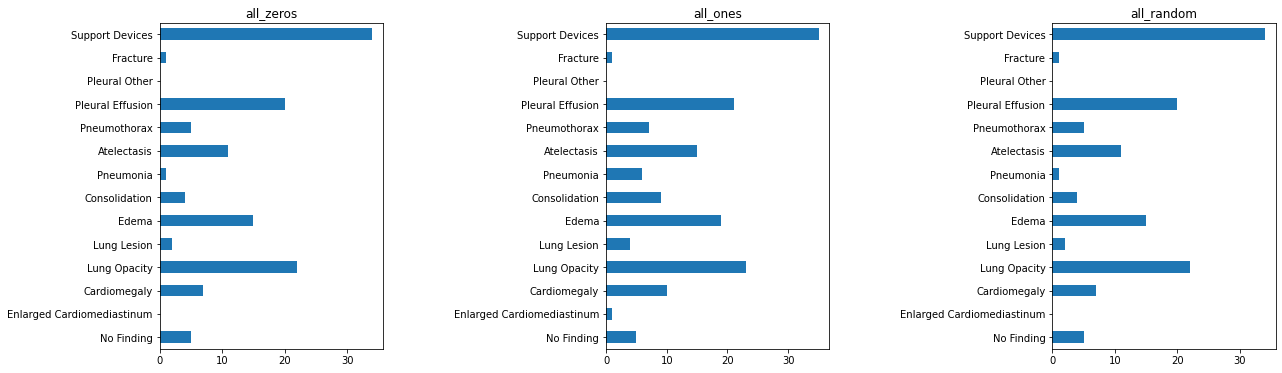

In [294]:
def plot_histograms(dataset_cases):
  # Takes a list of dataset cases and plots histograms
  # Define number of rows and columns for subplots
  
  nrow=1
  ncol=len(dataset_cases)

  # make a list of all dataframes 
  df_list = [d for d in dataset_cases]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 6), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = .5, wspace=1.001)
  count=0
  for col in range(ncol):
    df_list[count].histogram(axes, col)
    count+=1

plot_histograms(dataset_cases)


At this step we can select which colums/labels we want keep in our process. Cause of lack of computation power we drop the majority of the classes.

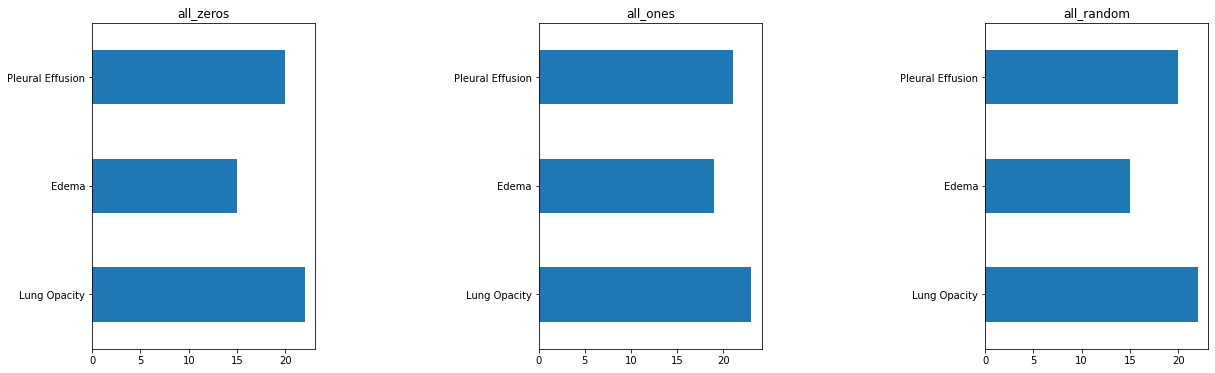

In [295]:
# drop desired columns and plot histograms to check dataset balance
to_drop = ['Pleural Other', 'Lung Lesion', 'No Finding', 
            'Enlarged Cardiomediastinum', 'Fracture', 'Consolidation', 
           'Pneumonia', 'Pneumothorax','Atelectasis', 'Cardiomegaly', 
           'Support Devices' ]

for case in dataset_cases:
  case.drop_columns(to_drop)


plot_histograms(dataset_cases)


## Split dataset into Train/Valid/Test sets

In [296]:
for case in dataset_cases:
  case.train_test_split(size = 0.8)
  case.summary()

Test Case: all_zeros - Number of labels: 3 - Selected Columns: ['Lung Opacity', 'Edema', 'Pleural Effusion']           Train set: (30, 4), Valid set: (4, 4), Test set: (3, 4)
Test Case: all_ones - Number of labels: 3 - Selected Columns: ['Lung Opacity', 'Edema', 'Pleural Effusion']           Train set: (30, 4), Valid set: (4, 4), Test set: (3, 4)
Test Case: all_random - Number of labels: 3 - Selected Columns: ['Lung Opacity', 'Edema', 'Pleural Effusion']           Train set: (30, 4), Valid set: (4, 4), Test set: (3, 4)


## Data Generation and Dataset Imbalance

* We will use the ImageDatageneration from keras, we create a flow of input data into NN model.
* We will calculate the class-weights of the train set in order to deal with imbalanced datasets

In [297]:
batch_size = 2
input_size = (75, 75)
for case in dataset_cases:
  train_datagen=ImageDataGenerator(rescale=1./255.)
  test_datagen=ImageDataGenerator(rescale=1./255.)
  valid_datagen=ImageDataGenerator(rescale=1./255.)
  print(f'{case.test_case} - Data generator')
  case.data_generator(train_generator=train_datagen,
                      test_generator=test_datagen,
                      valid_generator=valid_datagen,
                      batch_size=batch_size,
                      input_size=input_size,
                      shuffle=True)

all_zeros - Data generator
Found 30 validated image filenames.
Found 4 validated image filenames.
Found 3 validated image filenames.
all_ones - Data generator
Found 30 validated image filenames.
Found 4 validated image filenames.
Found 3 validated image filenames.
all_random - Data generator
Found 30 validated image filenames.
Found 4 validated image filenames.
Found 3 validated image filenames.


In [298]:
for case in dataset_cases:
  print(f'{case.test_case} - Class weights')
  case.calculate_weights()

all_zeros - Class weights
{0: 0.5555555555555556, 1: 0.8333333333333334, 2: 0.5263157894736842}
all_ones - Class weights
{0: 0.47619047619047616, 1: 0.5555555555555556, 2: 0.5555555555555556}
all_random - Class weights
{0: 0.5263157894736842, 1: 0.8333333333333334, 2: 0.5555555555555556}


## Define Model and Metrics

We will use pre-trained model DenseNet121. Since we are dealing with a multi-label classification problem, we need to define usefull metrics that will help to assess the performance of the model.

In [299]:
def get_metrics() :
  return [
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      # keras.metrics.BinaryAccuracy(name='accuracy'),
      # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### DenseNet121 model creation and Pipeline

In [303]:
def pipeline(case, epochs):
  #model architecture design/selection
  #EfficientNetB0/DenseNet121
  input = tf.keras.Input(shape=(*input_size,3))
  base_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                              include_top = False, 
                                              input_tensor = input)

  # Now that we apply global max pooling.
  gap = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)

  # add a fully-connected layer
  fc = tf.keras.layers.Dense(1024, activation='relu')(gap)

  # Finally, we add a classification layer.
  output = tf.keras.layers.Dense(case.num_classes, activation='sigmoid')(fc)

  for layer in base_model.layers:
      layer.trainable = True

  # bind all
  model = tf.keras.Model(base_model.input, output)
  adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer= adam, 
                loss='binary_crossentropy', 
                metrics=['accuracy', 
                        f1_m,precision_m, 
                        recall_m, 
                        get_metrics()])

  # model.summary()

  #Tensorboard
  log_dir = "logs/"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  # Checkpoint to save best model
  model_name = 'densenet121_' + case.test_case + '.hdf5'
  checkpoint = ModelCheckpoint('drive/MyDrive/DriveUploader/'+ model_name, save_best_only = True, monitor = 'val_loss', verbose = 1)

  model_h = model.fit(case.train_generator,
                      steps_per_epoch=case.STEP_SIZE_TRAIN,
                      validation_data=case.valid_generator, 
                      validation_steps=case.STEP_SIZE_VALID, 
                      epochs=epochs,
                      callbacks=[checkpoint],
                      class_weight = case.class_weights)
  
  case.model = model
  case.model_history = model_h


In [304]:
for case in dataset_cases:
  print(f'Training case {case.test_case}')
  pipeline(case = case, epochs = 1)


Training case all_zeros
15/15 [==============================] - 30s 571ms/step - loss: 0.6803 - accuracy: 0.4000 - f1_m: 0.4571 - precision_m: 0.4644 - recall_m: 0.5000 - auc: 0.3568 - prc: 0.4457 - val_loss: 2.8319 - val_accuracy: 0.0000e+00 - val_f1_m: 0.5714 - val_precision_m: 0.5000 - val_recall_m: 0.6667 - val_auc: 0.4711 - val_prc: 0.5458

Epoch 00001: val_loss improved from inf to 2.83185, saving model to drive/MyDrive/DriveUploader/densenet121_all_zeros.hdf5
Training case all_ones
15/15 [==============================] - 23s 517ms/step - loss: 0.6921 - accuracy: 0.3333 - f1_m: 0.5722 - precision_m: 0.5600 - recall_m: 0.6200 - auc: 0.4411 - prc: 0.5538 - val_loss: 1.4376 - val_accuracy: 0.0000e+00 - val_f1_m: 0.4762 - val_precision_m: 0.3500 - val_recall_m: 0.7500 - val_auc: 0.4510 - val_prc: 0.5987

Epoch 00001: val_loss improved from inf to 1.43759, saving model to drive/MyDrive/DriveUploader/densenet121_all_ones.hdf5
Training case all_random
15/15 [==========================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


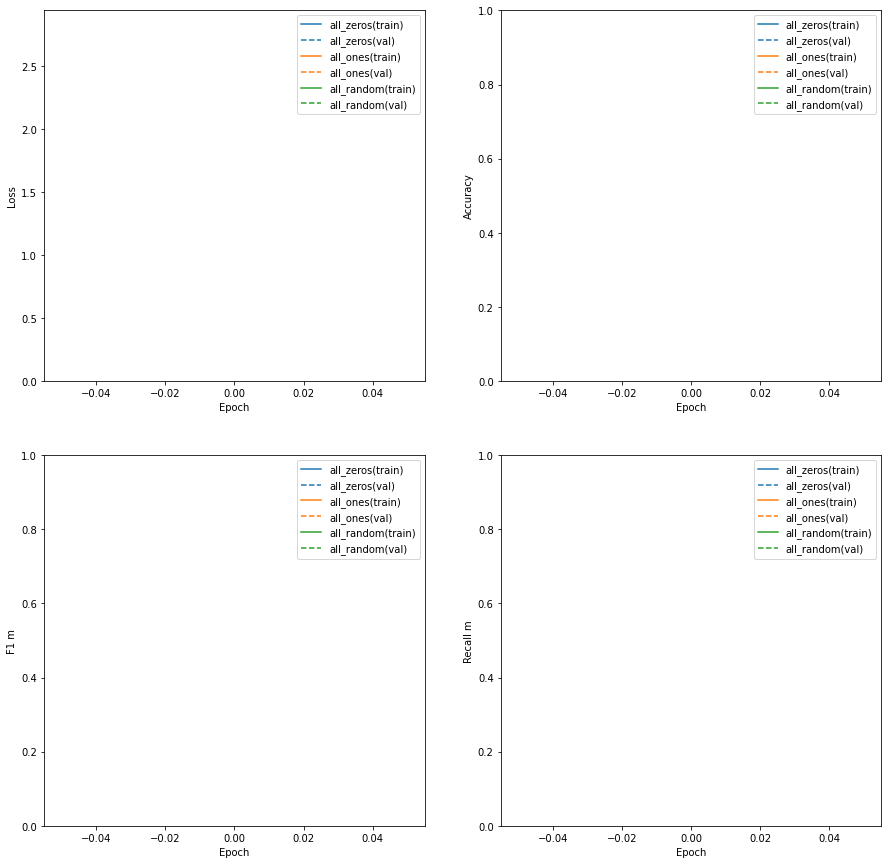

In [305]:
plt.rcParams["figure.figsize"] = (15,15)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(case, metrics, color_index):
  #['loss', 'accuracy', 'f1_m', 'recall_m']
  model_history = case.model_history
  test_case = case.test_case
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(model_history.epoch, model_history.history[metric], color=colors[color_index], label=f'{test_case}(train)')
    plt.plot(model_history.epoch, model_history.history['val_'+metric],
             color=colors[color_index], linestyle="--", label=f'{test_case}(val)')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

color_index = 0
for case in dataset_cases:
  plot_metrics(case, ['loss', 'accuracy','f1_m', 'recall_m'], color_index)
  color_index +=1

## Evaluation Metrics
You can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

Evaluating case all_zeros
3/3 [==============================] - 2s 40ms/step


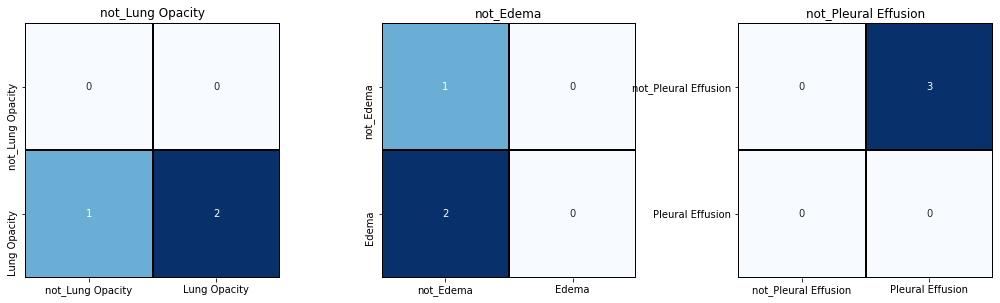

Evaluating case all_ones
3/3 [==============================] - 2s 39ms/step


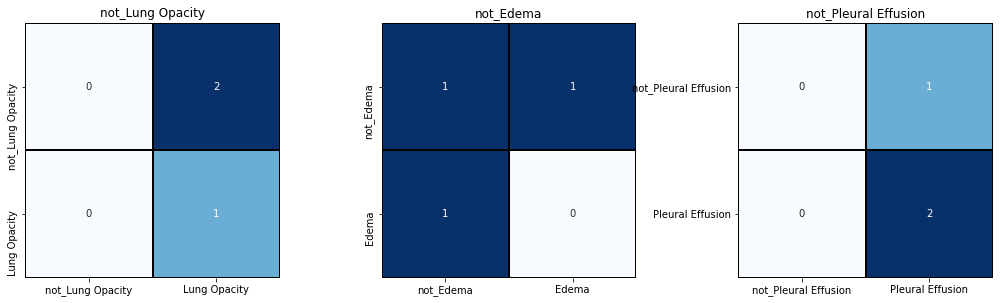

Evaluating case all_random
3/3 [==============================] - 2s 49ms/step


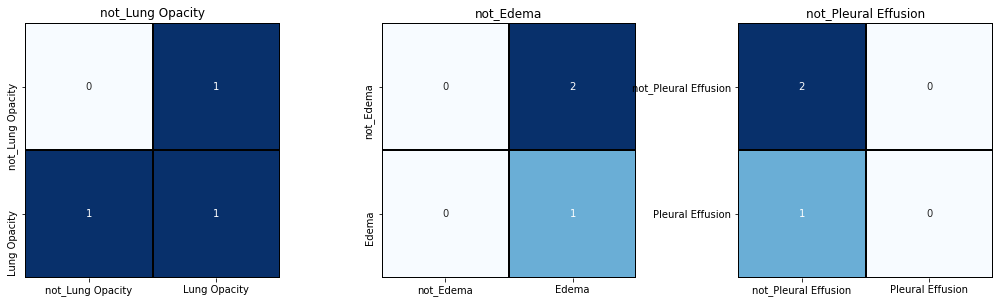

In [306]:
from sklearn.metrics import multilabel_confusion_matrix
for case in dataset_cases:
  print(f'Evaluating case {case.test_case}')
  # Predicting test images
  preds = case.model.predict(case.test_generator, steps=case.STEP_SIZE_TEST, verbose=1)
  preds = np.where(preds < 0.5, 0, 1)


  y_true = case.test_generator.labels
  classes = case.df.columns[1:case.num_classes+1]

  # Creating multilabel confusion matrix
  confusion = multilabel_confusion_matrix(y_true, preds)
  # Plot confusion matrix 
  fig = plt.figure(figsize = (14, 8))
  for i, (label, matrix) in enumerate(zip(classes, confusion)):
      plt.subplot(f'23{i+1}')
      labels = [f'not_{label}', label]
      sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                  xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
      plt.title(labels[0])

  plt.tight_layout()
  plt.show()

Evaluating AUROC for case all_zeros
3/3 [==============================] - 0s 37ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


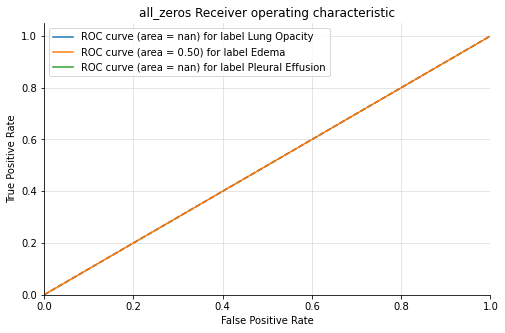

Evaluating AUROC for case all_ones
3/3 [==============================] - 0s 41ms/step


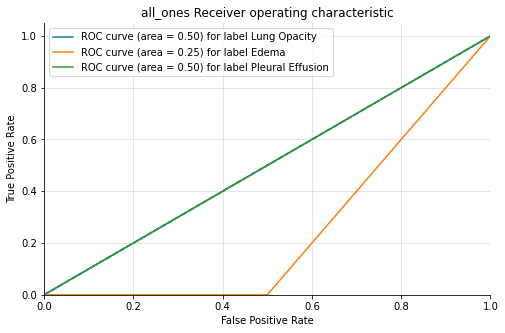

Evaluating AUROC for case all_random
3/3 [==============================] - 0s 41ms/step


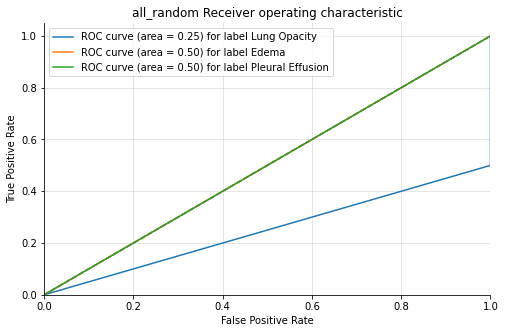

In [308]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# helper function
def plot_multiclass_roc(y_test, y_probs, model, labels, figsize=(17, 6)):
    
    n_classes = len(labels)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # roc for each class
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model} Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


for case in dataset_cases:
  print(f'Evaluating AUROC for case {case.test_case}')
  # Predicting test images
  preds = case.model.predict(case.test_generator, steps=case.STEP_SIZE_TEST, verbose=1)
  preds = np.where(preds < 0.5, 0, 1)


  y_true = case.test_generator.labels
  classes = case.df.columns[1:case.num_classes+1]
  
  plot_multiclass_roc(y_true, preds, case.test_case, classes, figsize = (8,5))